## Import

In [ ]:
import zipfile
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

## Data Loading from a zipped CSV file

In [3]:
# opening the zip csv file
zip_path = 'dataset/Alzheimer_s_Disease_and_Healthy_Aging_Data_20241126.zip'
with zipfile.ZipFile(zip_path, 'r') as z:
    print("Files in zip:", z.namelist())
    csv_file = z.namelist()[0]
    with z.open(csv_file) as f:
        df = pd.read_csv(f)
df.head()

Files in zip: ['Alzheimer_s_Disease_and_Healthy_Aging_Data_20241126.csv']


,RowId,YearStart,YearEnd,LocationAbbr,LocationDesc,Datasource,Class,Topic,Question,Data_Value_Unit,...,Stratification2,Geolocation,ClassID,TopicID,QuestionID,LocationID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2
0,BRFSS~2022~2022~42~Q03~TMC01~AGE~RACE,2022,2022,PA,Pennsylvania,BRFSS,Mental Health,Frequent mental distress,Percentage of older adults who are experiencin...,%,...,Native Am/Alaskan Native,POINT (-77.86070029 40.79373015),C05,TMC01,Q03,42,AGE,5064,RACE,NAA
1,BRFSS~2022~2022~46~Q03~TMC01~AGE~RACE,2022,2022,SD,South Dakota,BRFSS,Mental Health,Frequent mental distress,Percentage of older adults who are experiencin...,%,...,Asian/Pacific Islander,POINT (-100.3735306 44.35313005),C05,TMC01,Q03,46,AGE,65PLUS,RACE,ASN
2,BRFSS~2022~2022~16~Q03~TMC01~AGE~RACE,2022,2022,ID,Idaho,BRFSS,Mental Health,Frequent mental distress,Percentage of older adults who are experiencin...,%,...,"Black, non-Hispanic",POINT (-114.36373 43.68263001),C05,TMC01,Q03,16,AGE,65PLUS,RACE,BLK
3,BRFSS~2022~2022~24~Q03~TMC01~AGE~RACE,2022,2022,MD,Maryland,BRFSS,Mental Health,Frequent mental distress,Percentage of older adults who are experiencin...,%,...,"Black, non-Hispanic",POINT (-76.60926011 39.29058096),C05,TMC01,Q03,24,AGE,65PLUS,RACE,BLK
4,BRFSS~2022~2022~55~Q03~TMC01~AGE~GENDER,2022,2022,WI,Wisconsin,BRFSS,Mental Health,Frequent mental distress,Percentage of older adults who are experiencin...,%,...,Male,POINT (-89.81637074 44.39319117),C05,TMC01,Q03,55,AGE,65PLUS,GENDER,MALE


## 

## How has the prevalence of Alzheimer changed from 2015 to 2022 across different class?

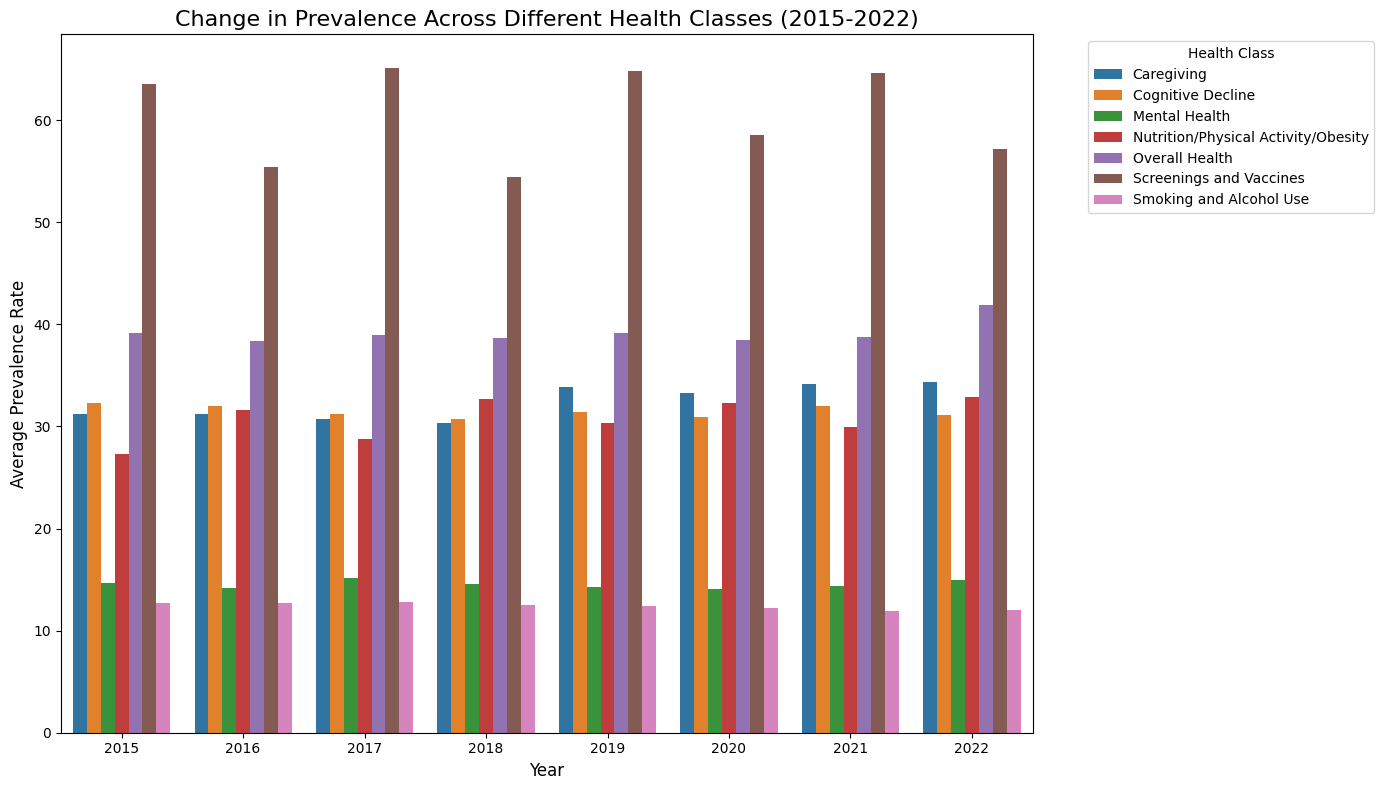

In [4]:
df_filtered = df[(df['YearStart'] >= 2015) & (df['YearEnd'] <= 2022)]
df_grouped_prevalance = df_filtered.groupby(['Class', 'YearStart'])['Data_Value'].mean().reset_index()
plt.figure(figsize=(14, 8))
sns.barplot(data=df_grouped_prevalance, x='YearStart', y='Data_Value', hue='Class', errorbar=None)
plt.title('Change in Prevalence Across Different Health Classes (2015-2022)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Prevalence Rate', fontsize=12)
plt.legend(title='Health Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Stratification Analysis : Prevalence by Age Group

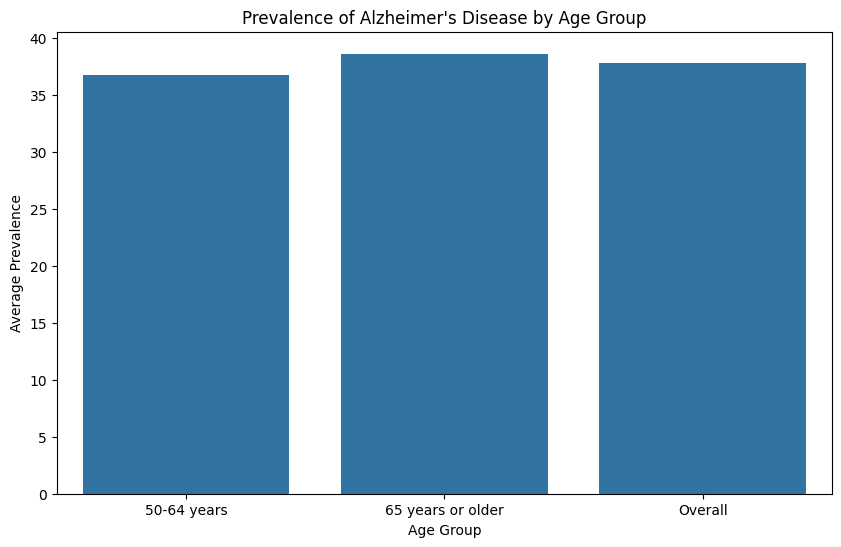

In [8]:
df_stratification = df.groupby('Stratification1')['Data_Value'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=df_stratification, x='Stratification1', y='Data_Value')
plt.title('Prevalence of Alzheimer\'s Disease by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Prevalence')
plt.show()

## Confidence Interval Analysis

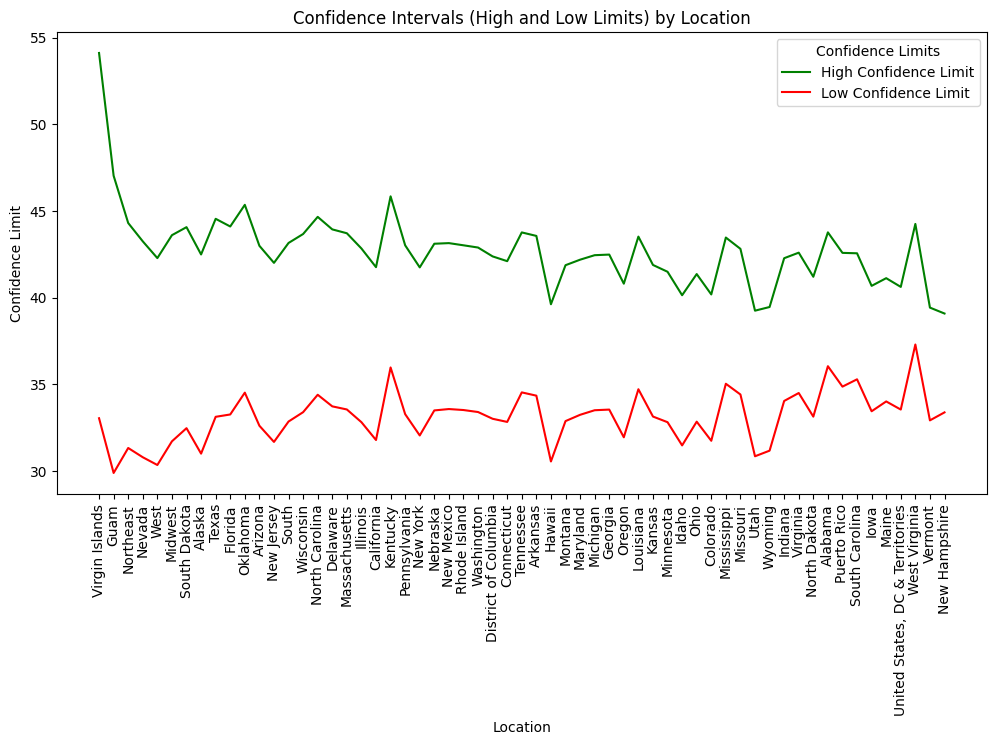

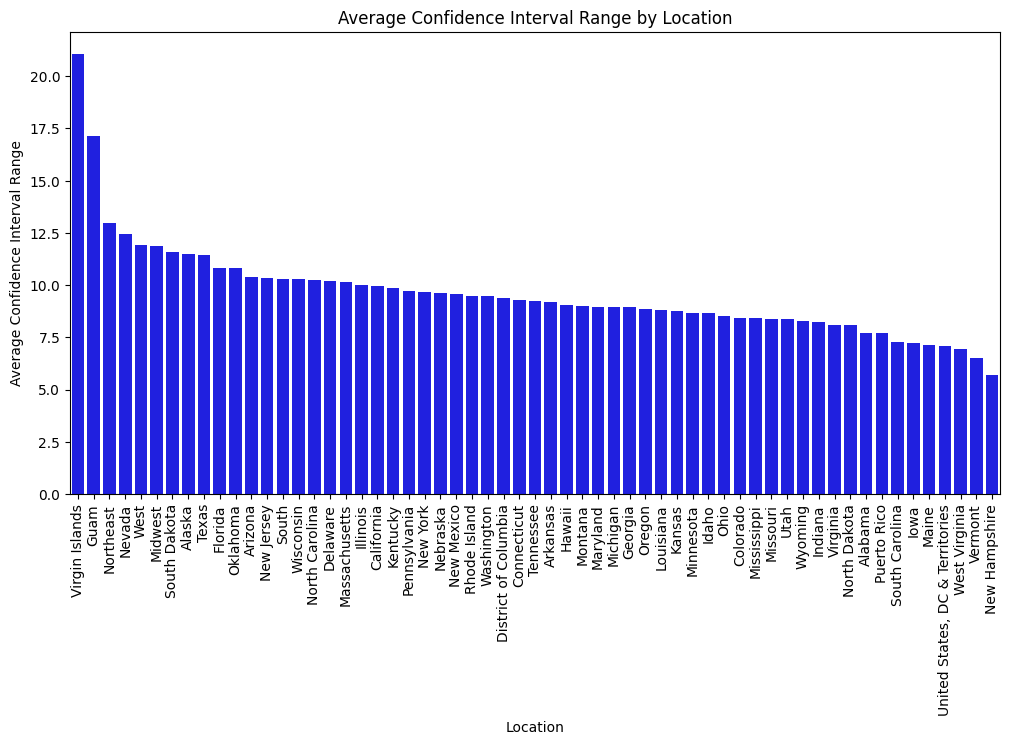

In [20]:
df['Confidence_Interval_Range'] = df['High_Confidence_Limit'] - df['Low_Confidence_Limit']
df_location_confidence = df.groupby('LocationDesc').agg({
    'Low_Confidence_Limit': 'mean',
    'High_Confidence_Limit': 'mean',
    'Confidence_Interval_Range': 'mean'
}).reset_index()
df_location_confidence_sorted = df_location_confidence.sort_values('Confidence_Interval_Range', ascending=False)
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_location_confidence_sorted, x='LocationDesc', y='High_Confidence_Limit', label='High Confidence Limit', color='green')
sns.lineplot(data=df_location_confidence_sorted, x='LocationDesc', y='Low_Confidence_Limit', label='Low Confidence Limit', color='red')
plt.title('Confidence Intervals (High and Low Limits) by Location')
plt.xlabel('Location')
plt.ylabel('Confidence Limit')
plt.xticks(rotation=90)
plt.legend(title='Confidence Limits')
plt.show()

# Confidence Interval Range
plt.figure(figsize=(12, 6))
sns.barplot(data=df_location_confidence_sorted, x='LocationDesc', y='Confidence_Interval_Range', color='blue')
plt.title('Average Confidence Interval Range by Location')
plt.xlabel('Location')
plt.ylabel('Average Confidence Interval Range')
plt.xticks(rotation=90)
plt.show()

## Descriptive Statistics

In [ ]:
df['Data_Value'].describe()

count    284142.000000
mean         25.566020
std          27.221298
min           0.000000
25%           0.000000
50%          16.800000
75%          42.400000
max         100.000000
Name: Data_Value, dtype: float64

## Predict the prevalence based on stratifications 

In [ ]:
df_model = df[['Stratification1', 'YearStart', 'Data_Value']]
df_model = pd.get_dummies(df_model, columns=['Stratification1'], drop_first=True)
X = df_model.drop(columns='Data_Value')
y = df_model['Data_Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 741.3744404161462


## Separating the data based on class 

In [5]:
# Grouping based on class and storing in different sheet in an excel
grouped = df.groupby('Class')
class_dfs = {class_name: group.reset_index(drop=True) for class_name, group in grouped}
output_directory = 'output' 
os.makedirs(output_directory, exist_ok=True)
output_file = os.path.join(output_directory, 'class_data_combined.xlsx')
with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
    for class_name, class_df in class_dfs.items():
        print(f"Sheet created for Class: {class_name}")
        sheet_name = str(class_name)[:31].replace(' ', '_').replace('/', '_')  # Remove spaces and slashes
        class_df.to_excel(writer, sheet_name=sheet_name, index=False)
print(f"Data saved to {output_file}")

Sheet created for Class: Caregiving
Sheet created for Class: Cognitive Decline
Sheet created for Class: Mental Health
Sheet created for Class: Nutrition/Physical Activity/Obesity
Sheet created for Class: Overall Health
Sheet created for Class: Screenings and Vaccines
Sheet created for Class: Smoking and Alcohol Use
Data saved to output\class_data_combined.xlsx


## How do caregiving statistics differ by topic across different locations?

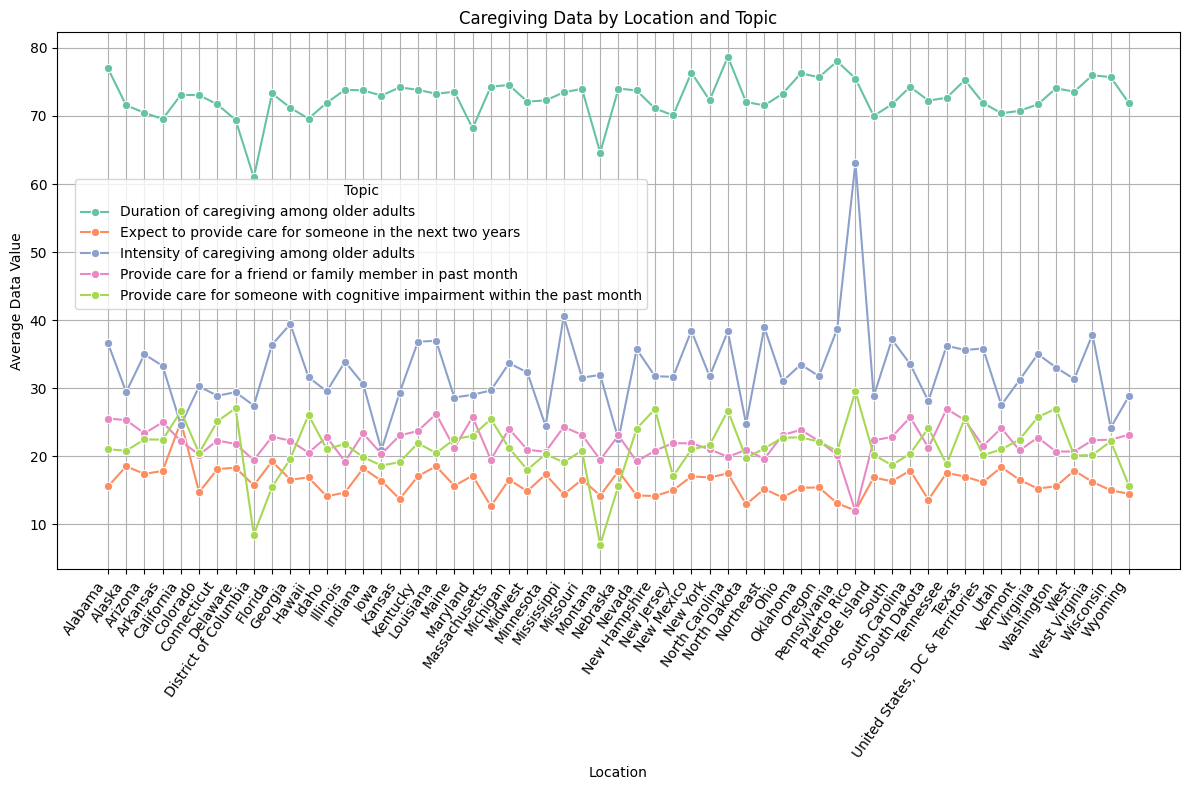

In [ ]:
df_caregiving = pd.read_excel('output/class_data_combined.xlsx',sheet_name='Caregiving')
df_filtered1 = df_caregiving[['LocationDesc', 'Topic', 'Data_Value']]
grouped_data = df_filtered1.groupby(['LocationDesc', 'Topic'])['Data_Value'].mean().reset_index()
plt.figure(figsize=(12, 8))
sns.lineplot(data=grouped_data, x='LocationDesc', y='Data_Value', hue='Topic', errorbar=None, palette='Set2',marker='o')
plt.grid()
plt.title('Caregiving Data by Location and Topic')
plt.xlabel('Location')
plt.ylabel('Average Data Value')
plt.xticks(rotation=55, ha='right')
plt.legend(title='Topic', bbox_to_anchor=(0.01, 0.74), loc='upper left', ncol=1)
plt.tight_layout()
plt.show()

## Cognitive Decline Average Confidence Level of different topic in different location

In [ ]:
df_Cognitive_Decline = pd.read_excel('output/class_data_combined.xlsx',sheet_name='Cognitive_Decline')
df_Cognitive_Decline['Average_Confidence_Level'] = (df_Cognitive_Decline['Low_Confidence_Limit'] + df_Cognitive_Decline['High_Confidence_Limit']) / 2

avg_confidence_by_location = (
    df_Cognitive_Decline.groupby(['LocationDesc', 'Topic'])['Average_Confidence_Level']
    .mean()
    .reset_index()
)
avg_confidence_by_location


,LocationDesc,Topic,Average_Confidence_Level
0,Alabama,Functional difficulties associated with subjec...,46.418889
1,Alabama,Need assistance with day-to-day activities bec...,40.698889
2,Alabama,Subjective cognitive decline or memory loss am...,14.184444
3,Alabama,Talked with health care professional about sub...,44.346667
4,Alaska,Functional difficulties associated with subjec...,33.040476
...,...,...,...
223,Wisconsin,Talked with health care professional about sub...,44.861607
224,Wyoming,Functional difficulties associated with subjec...,30.766667
225,Wyoming,Need assistance with day-to-day activities bec...,25.400000
226,Wyoming,Subjective cognitive decline or memory loss am...,9.358333


## Location having the highest Average Confidence Level on different topics of Cognitive Decline

In [100]:
highest_confidence_by_topic = (
    avg_confidence_by_location.loc[avg_confidence_by_location.groupby('Topic')['Average_Confidence_Level'].idxmax()]
)
highest_confidence_by_topic


,LocationDesc,Topic,Average_Confidence_Level
164,Puerto Rico,Functional difficulties associated with subjec...,64.431034
165,Puerto Rico,Need assistance with day-to-day activities bec...,62.753448
186,Tennessee,Subjective cognitive decline or memory loss am...,15.675333
167,Puerto Rico,Talked with health care professional about sub...,64.424138


## Mental Health data value based on Gender and Race/Ethnicity

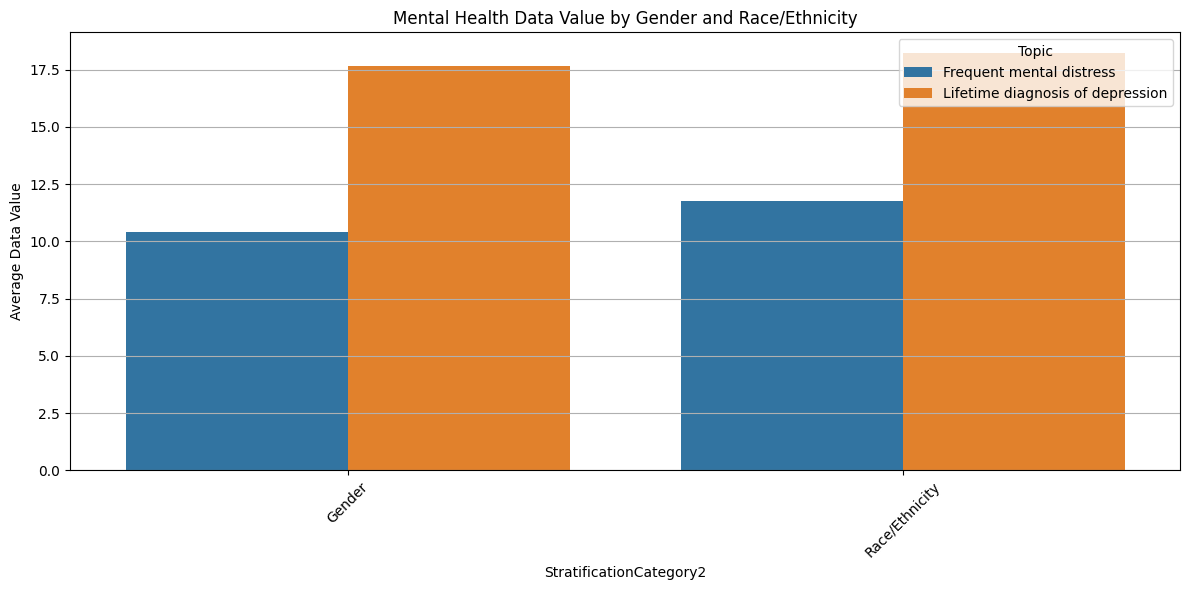

In [111]:
df_mental_health = pd.read_excel('output/class_data_combined.xlsx',sheet_name='Mental_Health')
mental_health_by_gender_ethnicity = (
    df_mental_health.groupby(['StratificationCategory2', 'Topic'])['Data_Value']
    .mean()
    .reset_index()
)
plt.figure(figsize=(12, 6))
plt.grid()
sns.barplot(
    data=mental_health_by_gender_ethnicity,
    x='StratificationCategory2',
    y='Data_Value',
    hue='Topic'
)
plt.title('Mental Health Data Value by Gender and Race/Ethnicity')
plt.xlabel('StratificationCategory2')
plt.ylabel('Average Data Value')
plt.xticks(rotation=45)
plt.legend(title='Topic', loc='upper right')
plt.tight_layout()
plt.show()


## Data value of Screening and Vaccine in each Race/Ethnicity

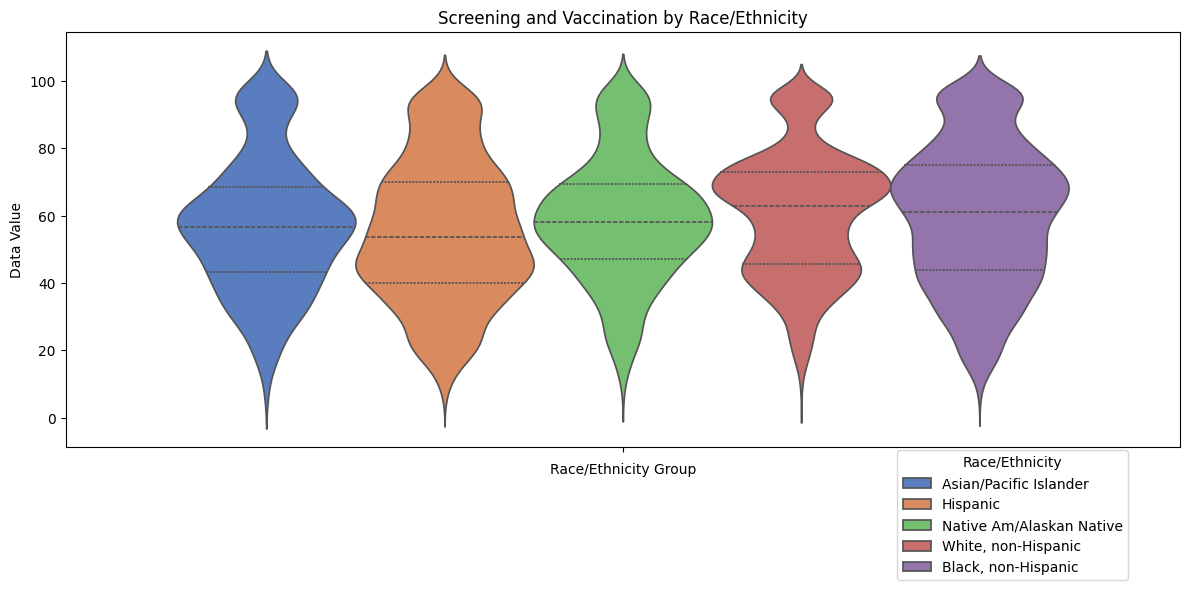

In [ ]:
df_Screenings_and_Vaccines = pd.read_excel('output/class_data_combined.xlsx', sheet_name='Screenings_and_Vaccines')
race_ethnicity_data = df_Screenings_and_Vaccines[
    df_Screenings_and_Vaccines['StratificationCategory2'].str.contains('race', case=False, na=False)
]
plt.figure(figsize=(12, 6))
sns.violinplot(
    data=race_ethnicity_data,
    hue='Stratification2', 
    y='Data_Value',
    inner="quart",
    palette="muted"
)
plt.title('Screening and Vaccination by Race/Ethnicity')
plt.xlabel('Race/Ethnicity Group')
plt.ylabel('Data Value')
plt.xticks(rotation=45)
plt.legend(title='Race/Ethnicity', loc='upper left',bbox_to_anchor=(0.74, 0.01))
plt.tight_layout()
plt.show()

## Smoking and Alcohol Use Based on Location and Topic

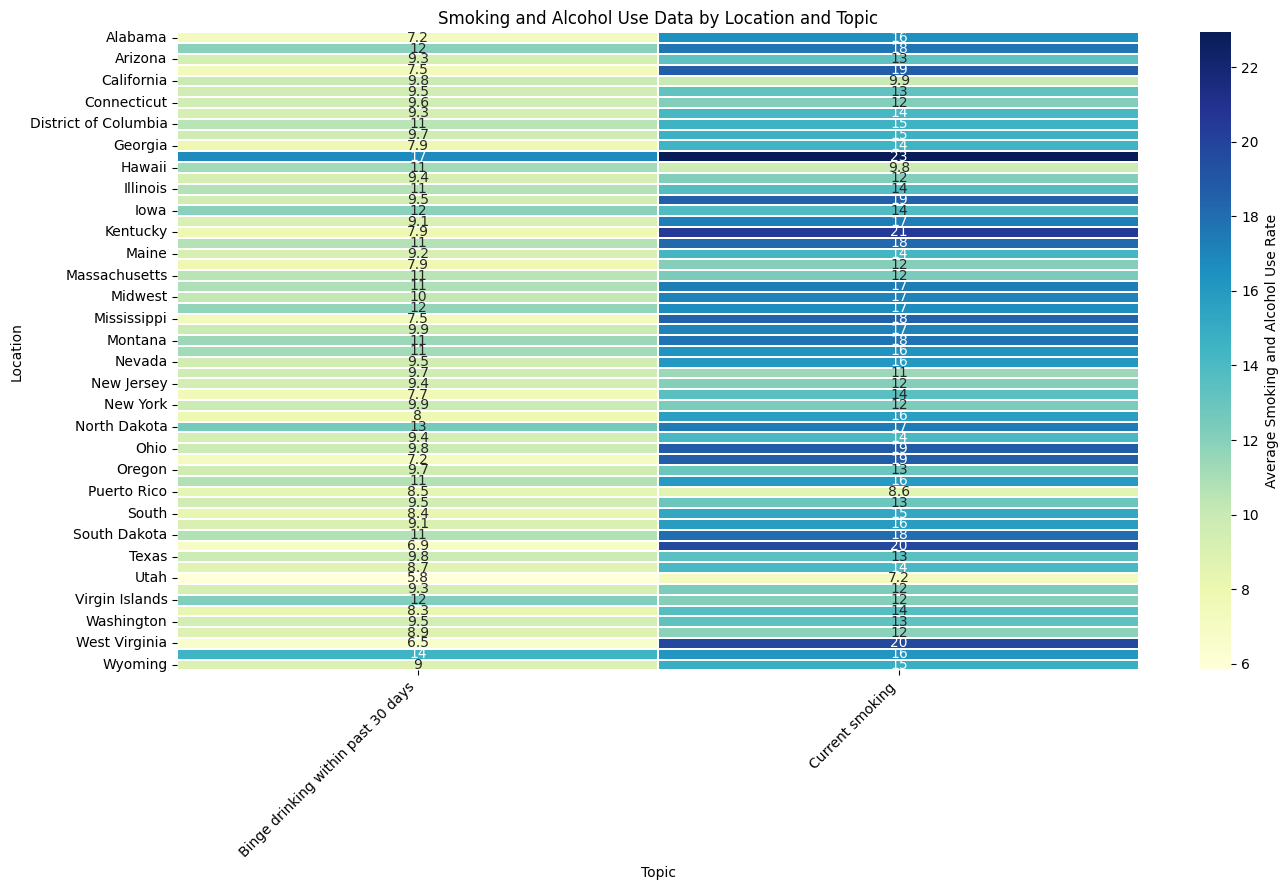

In [ ]:
df_Smoking_and_Alcohol_Use = pd.read_excel('output/class_data_combined.xlsx', sheet_name='Smoking_and_Alcohol_Use')
smoking_by_location_topic = df_Smoking_and_Alcohol_Use.groupby(['LocationDesc', 'Topic'])['Data_Value'].mean().reset_index()
smoking_pivot = smoking_by_location_topic.pivot(index='LocationDesc', columns='Topic', values='Data_Value')
plt.figure(figsize=(14, 9))
sns.heatmap(smoking_pivot, annot=True, cmap='YlGnBu', cbar_kws={'label': 'Average Smoking and Alcohol Use Rate'}, linewidths=0.01)
plt.title('Smoking and Alcohol Use Data by Location and Topic')
plt.xlabel('Topic')
plt.ylabel('Location')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Nutrition/Physical Activity/Obesity based on Gender

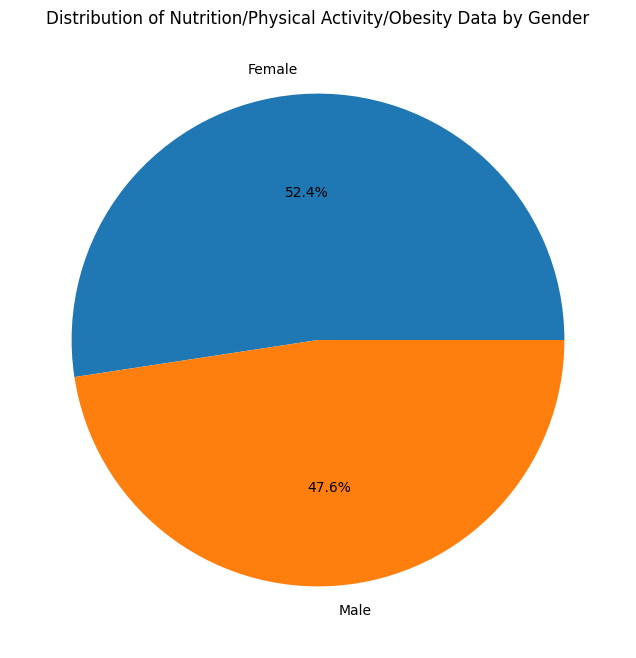

In [156]:
df_nutrition = pd.read_excel('output/class_data_combined.xlsx', sheet_name='Nutrition_Physical_Activity_Obe')
gender_data = df_nutrition[df_nutrition['StratificationCategory2'].str.contains('Gender', case=False, na=False)]
gender_grouped = gender_data.groupby('Stratification2')['Data_Value'].sum().reset_index()
plt.figure(figsize=(8, 8))
plt.pie(gender_grouped['Data_Value'], labels=gender_grouped['Stratification2'], autopct='%1.1f%%', colors=['#1f77b4', '#ff7f0e'])
plt.title('Distribution of Nutrition/Physical Activity/Obesity Data by Gender')
plt.show()


## Overall Health On Different Topics

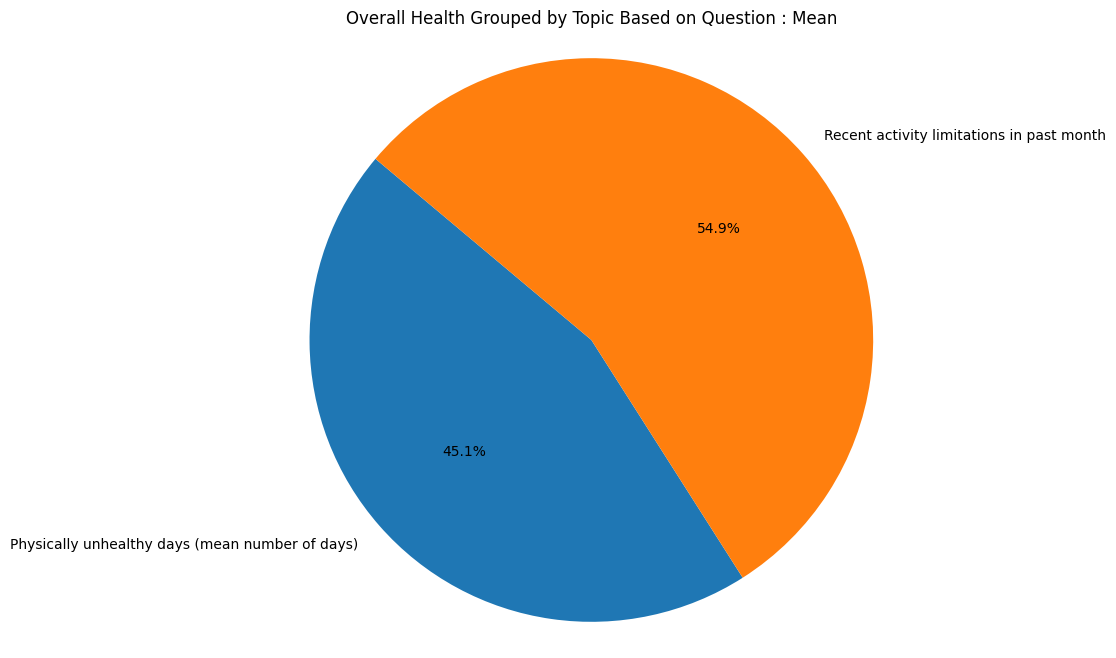

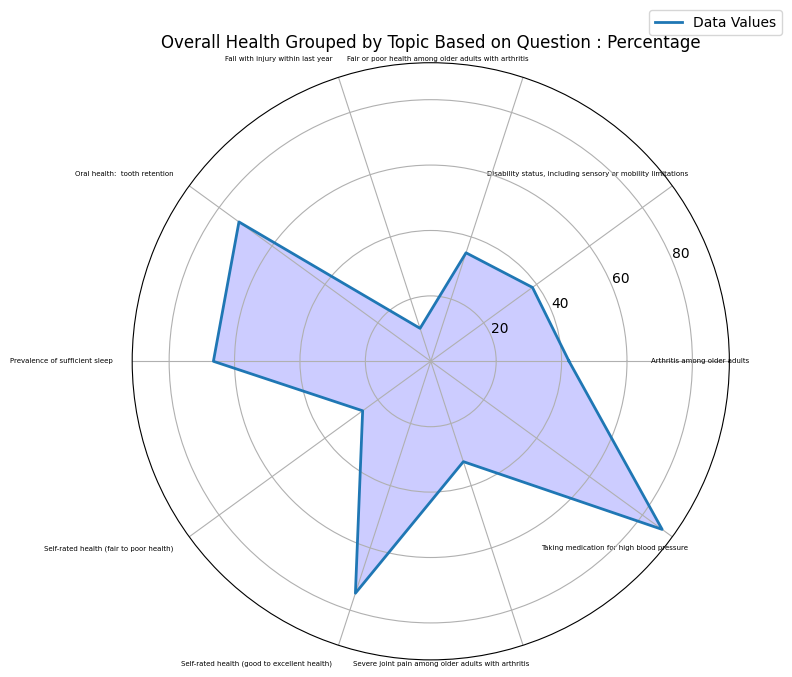

In [175]:
df_overall_health = pd.read_excel('output/class_data_combined.xlsx', sheet_name='Overall_Health')
df_overall_health['Data_Value'] = pd.to_numeric(df_overall_health['Data_Value'], errors='coerce')
df_overall_health = df_overall_health.dropna(subset=['Data_Value'])
# filter based on question
df_mean = df_overall_health[df_overall_health['Data_Value_Type'] == 'Mean']
df_percentage = df_overall_health[df_overall_health['Data_Value_Type'] == 'Percentage']
topics_to_plot = df_overall_health['Topic'].unique()
# for Pie chart (Mean values)
data_for_pie_mean = df_mean[df_mean['Topic'].isin(topics_to_plot)]
data_for_pie_avg_mean = data_for_pie_mean.groupby('Topic')['Data_Value'].mean().reset_index()
# for Radar chart (Percentage values)
data_for_radar_percentage = df_percentage[df_percentage['Topic'].isin(topics_to_plot)]
data_for_radar_avg_percentage = data_for_radar_percentage.groupby('Topic')['Data_Value'].mean().reset_index()

def plot_pie_chart(data_avg, chart_title):
    plt.figure(figsize=(8, 8))
    plt.pie(data_avg['Data_Value'], labels=data_avg['Topic'], autopct='%1.1f%%', startangle=140)
    plt.title(chart_title)
    plt.axis('equal')  
    plt.show()

def plot_radar_chart(data_avg, chart_title):
    categories = data_avg['Topic'].tolist()
    values = data_avg['Data_Value'].tolist()
    num_vars = len(categories)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    values += values[:1]
    angles += angles[:1]
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.plot(angles, values, linewidth=2, linestyle='solid', label='Data Values')
    ax.fill(angles, values, 'b', alpha=0.2)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=5, rotation=45, ha='right')
    plt.title(chart_title)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.tight_layout()
    plt.show()

plot_pie_chart(data_for_pie_avg_mean, 'Overall Health Grouped by Topic Based on Question : Mean')
plot_radar_chart(data_for_radar_avg_percentage, 'Overall Health Grouped by Topic Based on Question : Percentage')